In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy import stats
from itertools import cycle
from cmip_postprocess import *
from cmip_plot import plot_all_reg_cor_map
import warnings 
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')


2025-01-21 12:24:20.632543


In [2]:
# Path to the data
SSTA_PATH = '../data/processed/SSTA/'
SSTA_INDEX_PATH = '../data/processed/SSTA_INDEX/'
PRCP_ANO_PATH = '../data/processed/PRCP_ANOMALY/'
source_id = '../data/raw/source_id.txt'

OUT_REG_PATH = '../data/processed/regression/'
OUT_FIG_PATH = '../results/figures/'

## For NTA index

### 1. load the data

In [4]:
nta_index = load_from_pickle(SSTA_INDEX_PATH + 'nta_ssta.pkl')

# load the precipitation anomaly data, I have already processed the data in the previous notebook
lpf_prcp_ano = load_from_pickle(PRCP_ANO_PATH + 'lpf_ano_prcp.pkl')

In [7]:
list(lpf_prcp_ano.keys())

['CESM2-WACCM.gn.historical.Amon.r1i1p1f1',
 'CESM2-WACCM-FV2.gn.historical.Amon.r1i1p1f1',
 'CESM2-FV2.gn.historical.Amon.r1i1p1f1',
 'CESM2.gn.historical.Amon.r1i1p1f1',
 'TaiESM1.gn.historical.Amon.r1i1p1f1',
 'GISS-E2-1-H.gn.historical.Amon.r1i1p1f1',
 'BCC-ESM1.gn.historical.Amon.r1i1p1f1',
 'NESM3.gn.historical.Amon.r1i1p1f1',
 'GISS-E2-1-G-CC.gn.historical.Amon.r1i1p1f1',
 'CanESM5.gn.historical.Amon.r1i1p1f1',
 'BCC-CSM2-MR.gn.historical.Amon.r1i1p1f1',
 'GISS-E2-1-G.gn.historical.Amon.r1i1p1f1',
 'MPI-ESM-1-2-HAM.gn.historical.Amon.r1i1p1f1',
 'MPI-ESM1-2-LR.gn.historical.Amon.r1i1p1f1',
 'NorESM2-MM.gn.historical.Amon.r1i1p1f1',
 'IITM-ESM.gn.historical.Amon.r1i1p1f1',
 'MRI-ESM2-0.gn.historical.Amon.r1i1p1f1',
 'CMCC-CM2-SR5.gn.historical.Amon.r1i1p1f1',
 'FGOALS-g3.gn.historical.Amon.r1i1p1f1',
 'ACCESS-CM2.gn.historical.Amon.r1i1p1f1',
 'MPI-ESM1-2-HR.gn.historical.Amon.r1i1p1f1',
 'CAMS-CSM1-0.gn.historical.Amon.r1i1p1f1',
 'AWI-ESM-1-1-LR.gn.historical.Amon.r1i1p1f1',
 '

In [5]:
# Calculate equatorial precipitation (5S-5N) zonal average
eq_prcp = {}
for model in lpf_prcp_ano.keys():
    # Select latitude band between 5S-5N and take zonal mean
    eq_prcp[model] = lpf_prcp_ano[model].sel(lat=slice(-5, 5)).mean(dim='lat')


### 2. calculate the regression between equatorial precipitation and NTA index

In [6]:
model_names = [model.split('.')[0] for model in list(lpf_prcp_ano.keys())]

# Create a dictionary to hold the regression results for each model
regression_prcp_ano_nta = {}

# Loop over each model and calculate the regression
for model, nta_ds, prcp_ano_ds in zip(eq_prcp.keys(), 
                                 nta_index['lpf_data'].values(), 
                                 eq_prcp.values()):
    model = model.split('.')[0] # get cmip model names
    print('Starting regression for', model)
    if model in ['E3SM-MMF', 'E3SMv2', 'ERA5']:
        prcp_ano_ds = prcp_ano_ds.isel(time=slice(None, -1))
    else:
        prcp_ano_ds = prcp_ano_ds
    regression_prcp_ano_nta[model] = calculate_regression_vectorize(nta_ds, 
                                                            prcp_ano_ds)

Starting regression for CESM2-WACCM
Starting regression for CESM2-WACCM-FV2
Starting regression for CESM2-FV2
Starting regression for CESM2
Starting regression for TaiESM1
Starting regression for GISS-E2-1-H
Starting regression for BCC-ESM1
Starting regression for NESM3
Starting regression for GISS-E2-1-G-CC
Starting regression for CanESM5
Starting regression for BCC-CSM2-MR
Starting regression for GISS-E2-1-G
Starting regression for MPI-ESM-1-2-HAM
Starting regression for MPI-ESM1-2-LR
Starting regression for NorESM2-MM
Starting regression for IITM-ESM
Starting regression for MRI-ESM2-0
Starting regression for CMCC-CM2-SR5
Starting regression for FGOALS-g3
Starting regression for ACCESS-CM2
Starting regression for MPI-ESM1-2-HR
Starting regression for CAMS-CSM1-0
Starting regression for AWI-ESM-1-1-LR
Starting regression for CMCC-ESM2
Starting regression for SAM0-UNICON
Starting regression for MIROC6
Starting regression for CMCC-CM2-HR4
Starting regression for E3SM-MMF
Starting regres

In [7]:
# load the model ranking data
model_ranking = pd.read_csv('../data/processed/model_ranking.csv', index_col=0)

# sort the model by distance
model_ranking = model_ranking.sort_values('Distance')

# select the high skill models (Distance < 1) and low skill models (Distance > 1.5)
high_skill_models = model_ranking[model_ranking['Distance'] < 1].index.tolist()
high_skill_models = [model for model in high_skill_models if model != 'E3SMv2']
low_skill_models = model_ranking[model_ranking['Distance'] > 1.5].index.tolist()
low_skill_models = [model for model in low_skill_models if model != 'E3SM-MMF']


In [8]:
# calculate the ensemble mean for high skill models
high_skill_slopes = []
for model in high_skill_models:
    high_skill_slopes.append(regression_prcp_ano_nta[model].slope)
high_skill_mmm = np.mean(high_skill_slopes, axis=0)

# calculate the ensemble mean for low skill models
low_skill_slopes = []
for model in low_skill_models:
    low_skill_slopes.append(regression_prcp_ano_nta[model].slope)
low_skill_mmm = np.mean(low_skill_slopes, axis=0)

# convert to xarray DataArray format, keep the same coordinates as the original data
high_skill_mmm = xr.DataArray(
    data=high_skill_mmm,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_nta[high_skill_models[0]].lon}
)

low_skill_mmm = xr.DataArray(
    data=low_skill_mmm,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_nta[low_skill_models[0]].lon}
)



In [9]:
# calculate the standard deviation for high skill models
high_skill_slopes_array = np.array(high_skill_slopes)
high_skill_std = np.std(high_skill_slopes_array, axis=0)

# calculate the standard deviation for low skill models
low_skill_slopes_array = np.array(low_skill_slopes)
low_skill_std = np.std(low_skill_slopes_array, axis=0)

# convert to xarray DataArray format
high_skill_std = xr.DataArray(
    data=high_skill_std,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_nta[high_skill_models[0]].lon}
)

low_skill_std = xr.DataArray(
    data=low_skill_std,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_nta[low_skill_models[0]].lon}
)


### 3. plot the regression results for high skill models and low skill models

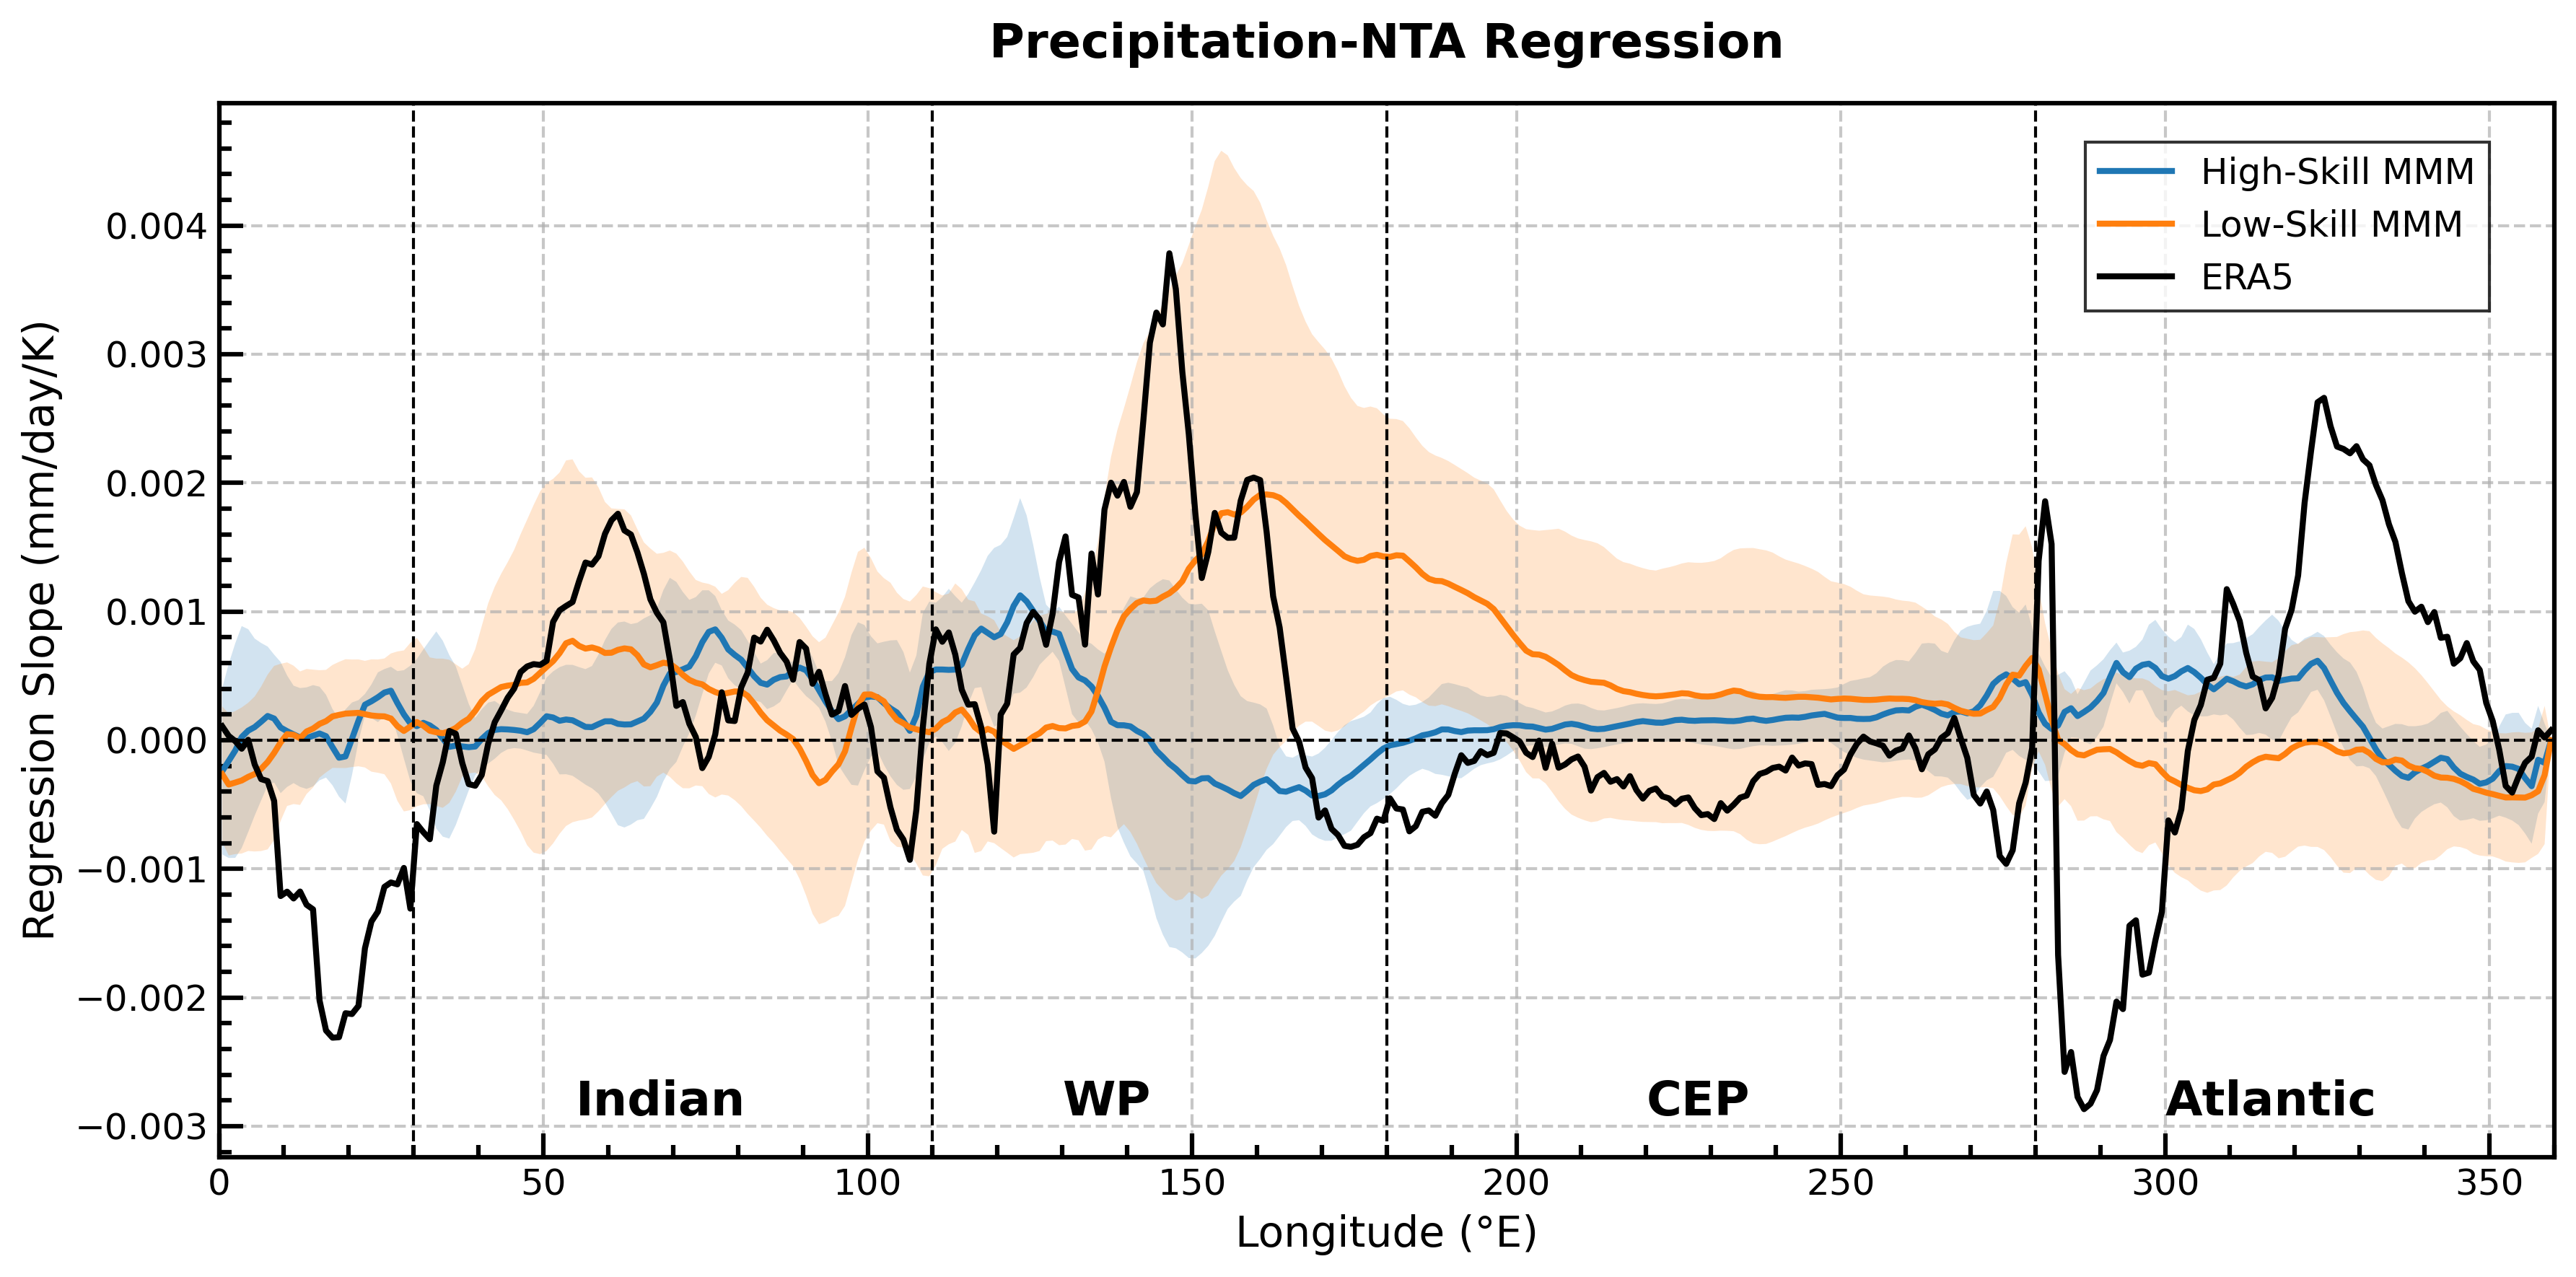

In [10]:
# First plot: NTA regression
plt.figure(figsize=(12, 6), dpi=300)

# Plot high skill MMM with shading
plt.plot(high_skill_mmm.lon, high_skill_mmm, label='High-Skill MMM', linewidth=2)
plt.fill_between(high_skill_mmm.lon, 
                 high_skill_mmm - high_skill_std,
                 high_skill_mmm + high_skill_std,
                 alpha=0.2)

# Plot low skill MMM with shading 
plt.plot(low_skill_mmm.lon, low_skill_mmm, label='Low-Skill MMM', linewidth=2)
plt.fill_between(low_skill_mmm.lon,
                 low_skill_mmm - low_skill_std, 
                 low_skill_mmm + low_skill_std,
                 alpha=0.2)

plt.plot(regression_prcp_ano_nta['ERA5'].lon, regression_prcp_ano_nta['ERA5'].slope, 
         label='ERA5', color='black', linewidth=2)

# Modify border style to make it bolder
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Add vertical lines
plt.axvline(30, color='k', linestyle='--', linewidth=1.0)
plt.axvline(110, color='k', linestyle='--', linewidth=1.0)
plt.axvline(180, color='k', linestyle='--', linewidth=1.0)
plt.axvline(280, color='k', linestyle='--', linewidth=1.0)

# Add horizontal line at y=0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1.0)

# Add region labels
y_position = plt.ylim()[0] * 0.9
plt.text(55, y_position, 'Indian', fontsize=16, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=16, fontweight='bold') 
plt.text(220, y_position, 'CEP', fontsize=16, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=16, fontweight='bold')

# Scientific style formatting
plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.0)
plt.legend(frameon=True, loc='upper right', fontsize=12, 
          bbox_to_anchor=(0.98, 0.98), 
          edgecolor='black', 
          fancybox=False)

plt.xlabel('Longitude (°E)', fontsize=14,)
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14, )
plt.title('Precipitation-NTA Regression', fontsize=16, fontweight='bold', pad=15)

# Set tick parameters
plt.tick_params(direction='in', length=8, width=1.5, which='major', labelsize=12)
plt.tick_params(direction='in', length=4, width=1.5, which='minor', labelsize=12)

# Add minor ticks
plt.minorticks_on()

# Set x-axis limits from 0 to 360
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()



### 4. plot the regression results for high skill models

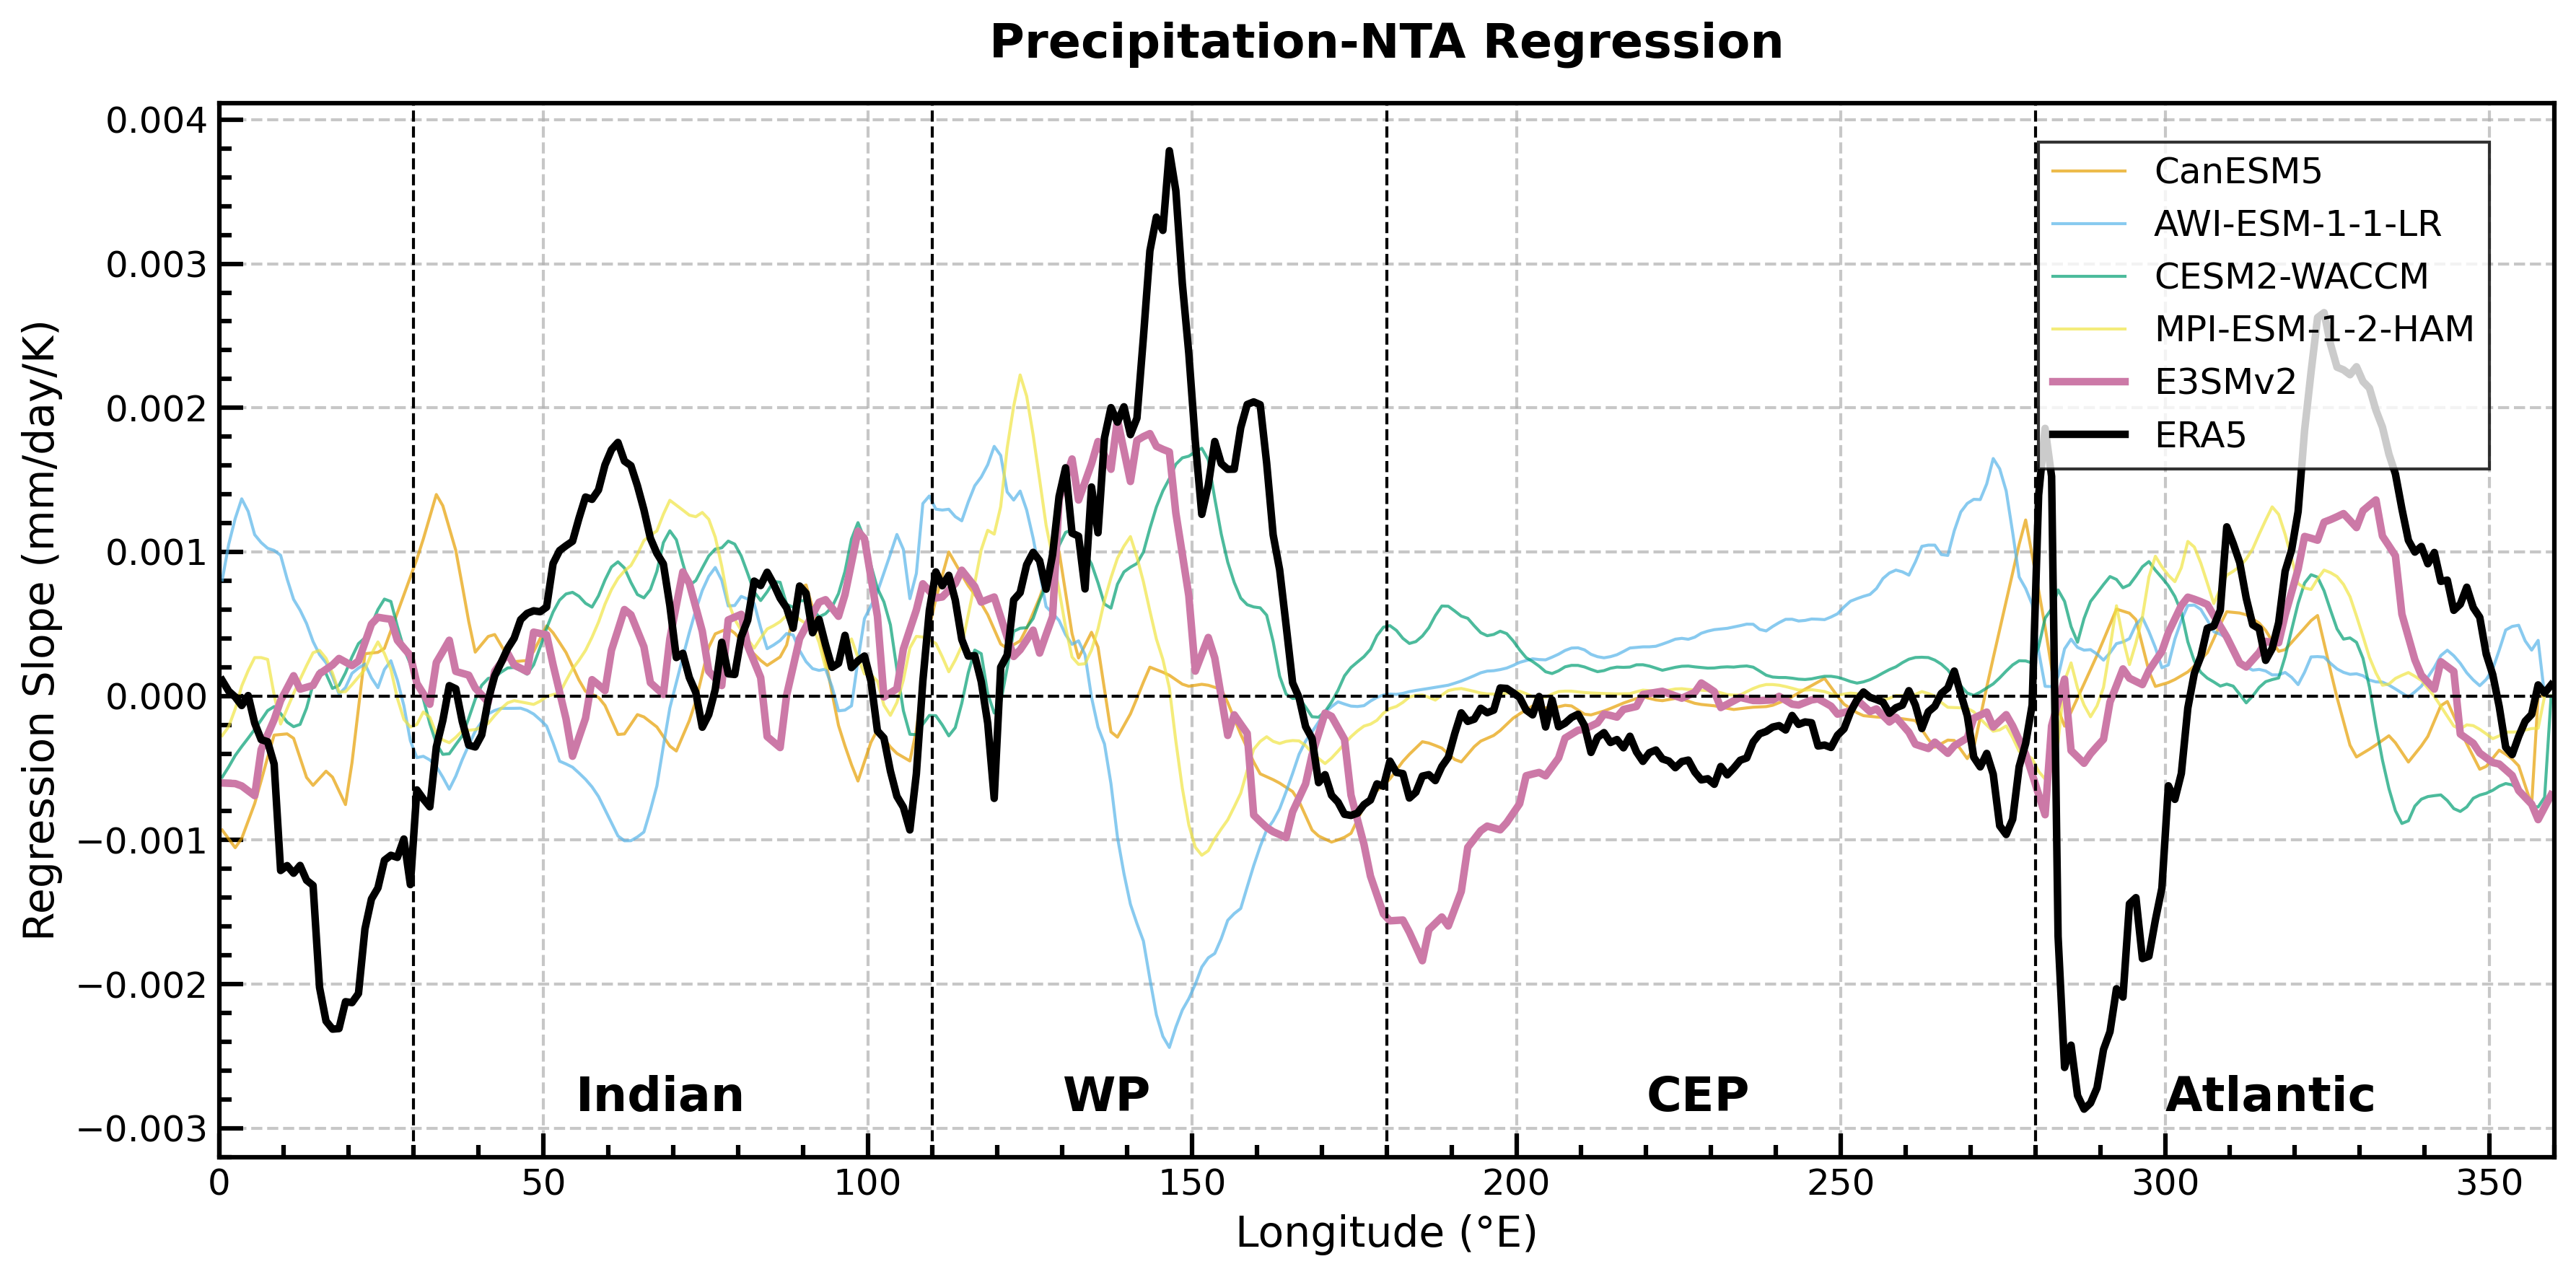

In [11]:
plt.figure(figsize=(12, 6), dpi=300)

colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']

high_skill_models = model_ranking[model_ranking['Distance'] < 1].index.tolist()
high_skill_models = [model for model in high_skill_models if model != 'E3SMv2']

# Plot individual models
for i, model in enumerate(high_skill_models):
    plt.plot(regression_prcp_ano_nta[model].lon, 
             regression_prcp_ano_nta[model].slope,
             label=model, linewidth=1, alpha=0.7,
             color=colors[i % len(colors)])

# Plot E3SMv2 and ERA5 with thicker lines
plt.plot(regression_prcp_ano_nta['E3SMv2'].lon, regression_prcp_ano_nta['E3SMv2'].slope,
         label='E3SMv2', linewidth=2.5, linestyle='-', color=colors[-2])

plt.plot(regression_prcp_ano_nta['ERA5'].lon, regression_prcp_ano_nta['ERA5'].slope, 
         label='ERA5', color='black', linewidth=2.5)

# Modify border style to make it bolder
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Add vertical lines
plt.axvline(30, color='k', linestyle='--', linewidth=1.0)
plt.axvline(110, color='k', linestyle='--', linewidth=1.0)
plt.axvline(180, color='k', linestyle='--', linewidth=1.0)
plt.axvline(280, color='k', linestyle='--', linewidth=1.0)

# Add horizontal line at y=0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1.0)

# Add region labels
y_position = plt.ylim()[0] * 0.9
plt.text(55, y_position, 'Indian', fontsize=16, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=16, fontweight='bold') 
plt.text(220, y_position, 'CEP', fontsize=16, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=16, fontweight='bold')

# Scientific style formatting
plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.0)
plt.legend(frameon=True, 
          loc='upper right', 
          fontsize=12,
          bbox_to_anchor=(0.98, 0.98),
          edgecolor='black',
          fancybox=False,
          ncol=1)

plt.xlabel('Longitude (°E)', fontsize=14)
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14)
plt.title('Precipitation-NTA Regression', 
         fontsize=16, fontweight='bold', pad=15)

# Set tick parameters
plt.tick_params(direction='in', length=8, width=1.5, which='major', labelsize=12)
plt.tick_params(direction='in', length=4, width=1.5, which='minor', labelsize=12)

# Add minor ticks
plt.minorticks_on()

# Set x-axis limits from 0 to 360
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()

## Precipitation regression on CTI index

The same steps are applied to the CTI index:

1. load the data
2. calculate the regression between equatorial precipitation and CTI index
3. plot the regression results for high-skill MMM  and low-skill MMM
4. plot the regression results for high skill models

In [12]:
cti_index = load_from_pickle(SSTA_INDEX_PATH + 'cti_ssta.pkl')

In [13]:
model_names = [model.split('.')[0] for model in list(lpf_prcp_ano.keys())]

# Create a dictionary to hold the regression results for each model
regression_prcp_ano_cti = {}

# Loop over each model and calculate the regression
for model, cti_ds, prcp_ano_ds in zip(eq_prcp.keys(), 
                                 cti_index['lpf_data'].values(), 
                                 eq_prcp.values()):
    model = model.split('.')[0] # get cmip model names
    print('Starting regression for', model)
    if model in ['E3SM-MMF', 'E3SMv2', 'ERA5']:
        prcp_ano_ds = prcp_ano_ds.isel(time=slice(None, -1))
    else:
        prcp_ano_ds = prcp_ano_ds
    regression_prcp_ano_cti[model] = calculate_regression_vectorize(cti_ds, 
                                                            prcp_ano_ds)



Starting regression for CESM2-WACCM
Starting regression for CESM2-WACCM-FV2
Starting regression for CESM2-FV2
Starting regression for CESM2
Starting regression for TaiESM1
Starting regression for GISS-E2-1-H
Starting regression for BCC-ESM1
Starting regression for NESM3
Starting regression for GISS-E2-1-G-CC
Starting regression for CanESM5
Starting regression for BCC-CSM2-MR
Starting regression for GISS-E2-1-G
Starting regression for MPI-ESM-1-2-HAM
Starting regression for MPI-ESM1-2-LR
Starting regression for NorESM2-MM
Starting regression for IITM-ESM
Starting regression for MRI-ESM2-0
Starting regression for CMCC-CM2-SR5
Starting regression for FGOALS-g3
Starting regression for ACCESS-CM2
Starting regression for MPI-ESM1-2-HR
Starting regression for CAMS-CSM1-0
Starting regression for AWI-ESM-1-1-LR
Starting regression for CMCC-ESM2
Starting regression for SAM0-UNICON
Starting regression for MIROC6
Starting regression for CMCC-CM2-HR4
Starting regression for E3SM-MMF
Starting regres

In [14]:
# calculate the ensemble mean for high skill models
high_skill_slopes = []
for model in high_skill_models:
    high_skill_slopes.append(regression_prcp_ano_cti[model].slope)
high_skill_mmm = np.mean(high_skill_slopes, axis=0)
high_skill_std = np.std(high_skill_slopes, axis=0)

# calculate the ensemble mean for low skill models
low_skill_slopes = []
for model in low_skill_models:
    low_skill_slopes.append(regression_prcp_ano_cti[model].slope)
low_skill_mmm = np.mean(low_skill_slopes, axis=0)
low_skill_std = np.std(low_skill_slopes, axis=0)

# convert to xarray DataArray format, keep the same coordinates as the original data
high_skill_mmm = xr.DataArray(
    data=high_skill_mmm,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_cti[high_skill_models[0]].lon}
)

low_skill_mmm = xr.DataArray(
    data=low_skill_mmm,
    dims=['lon'],
    coords={'lon': regression_prcp_ano_cti[low_skill_models[0]].lon}
)


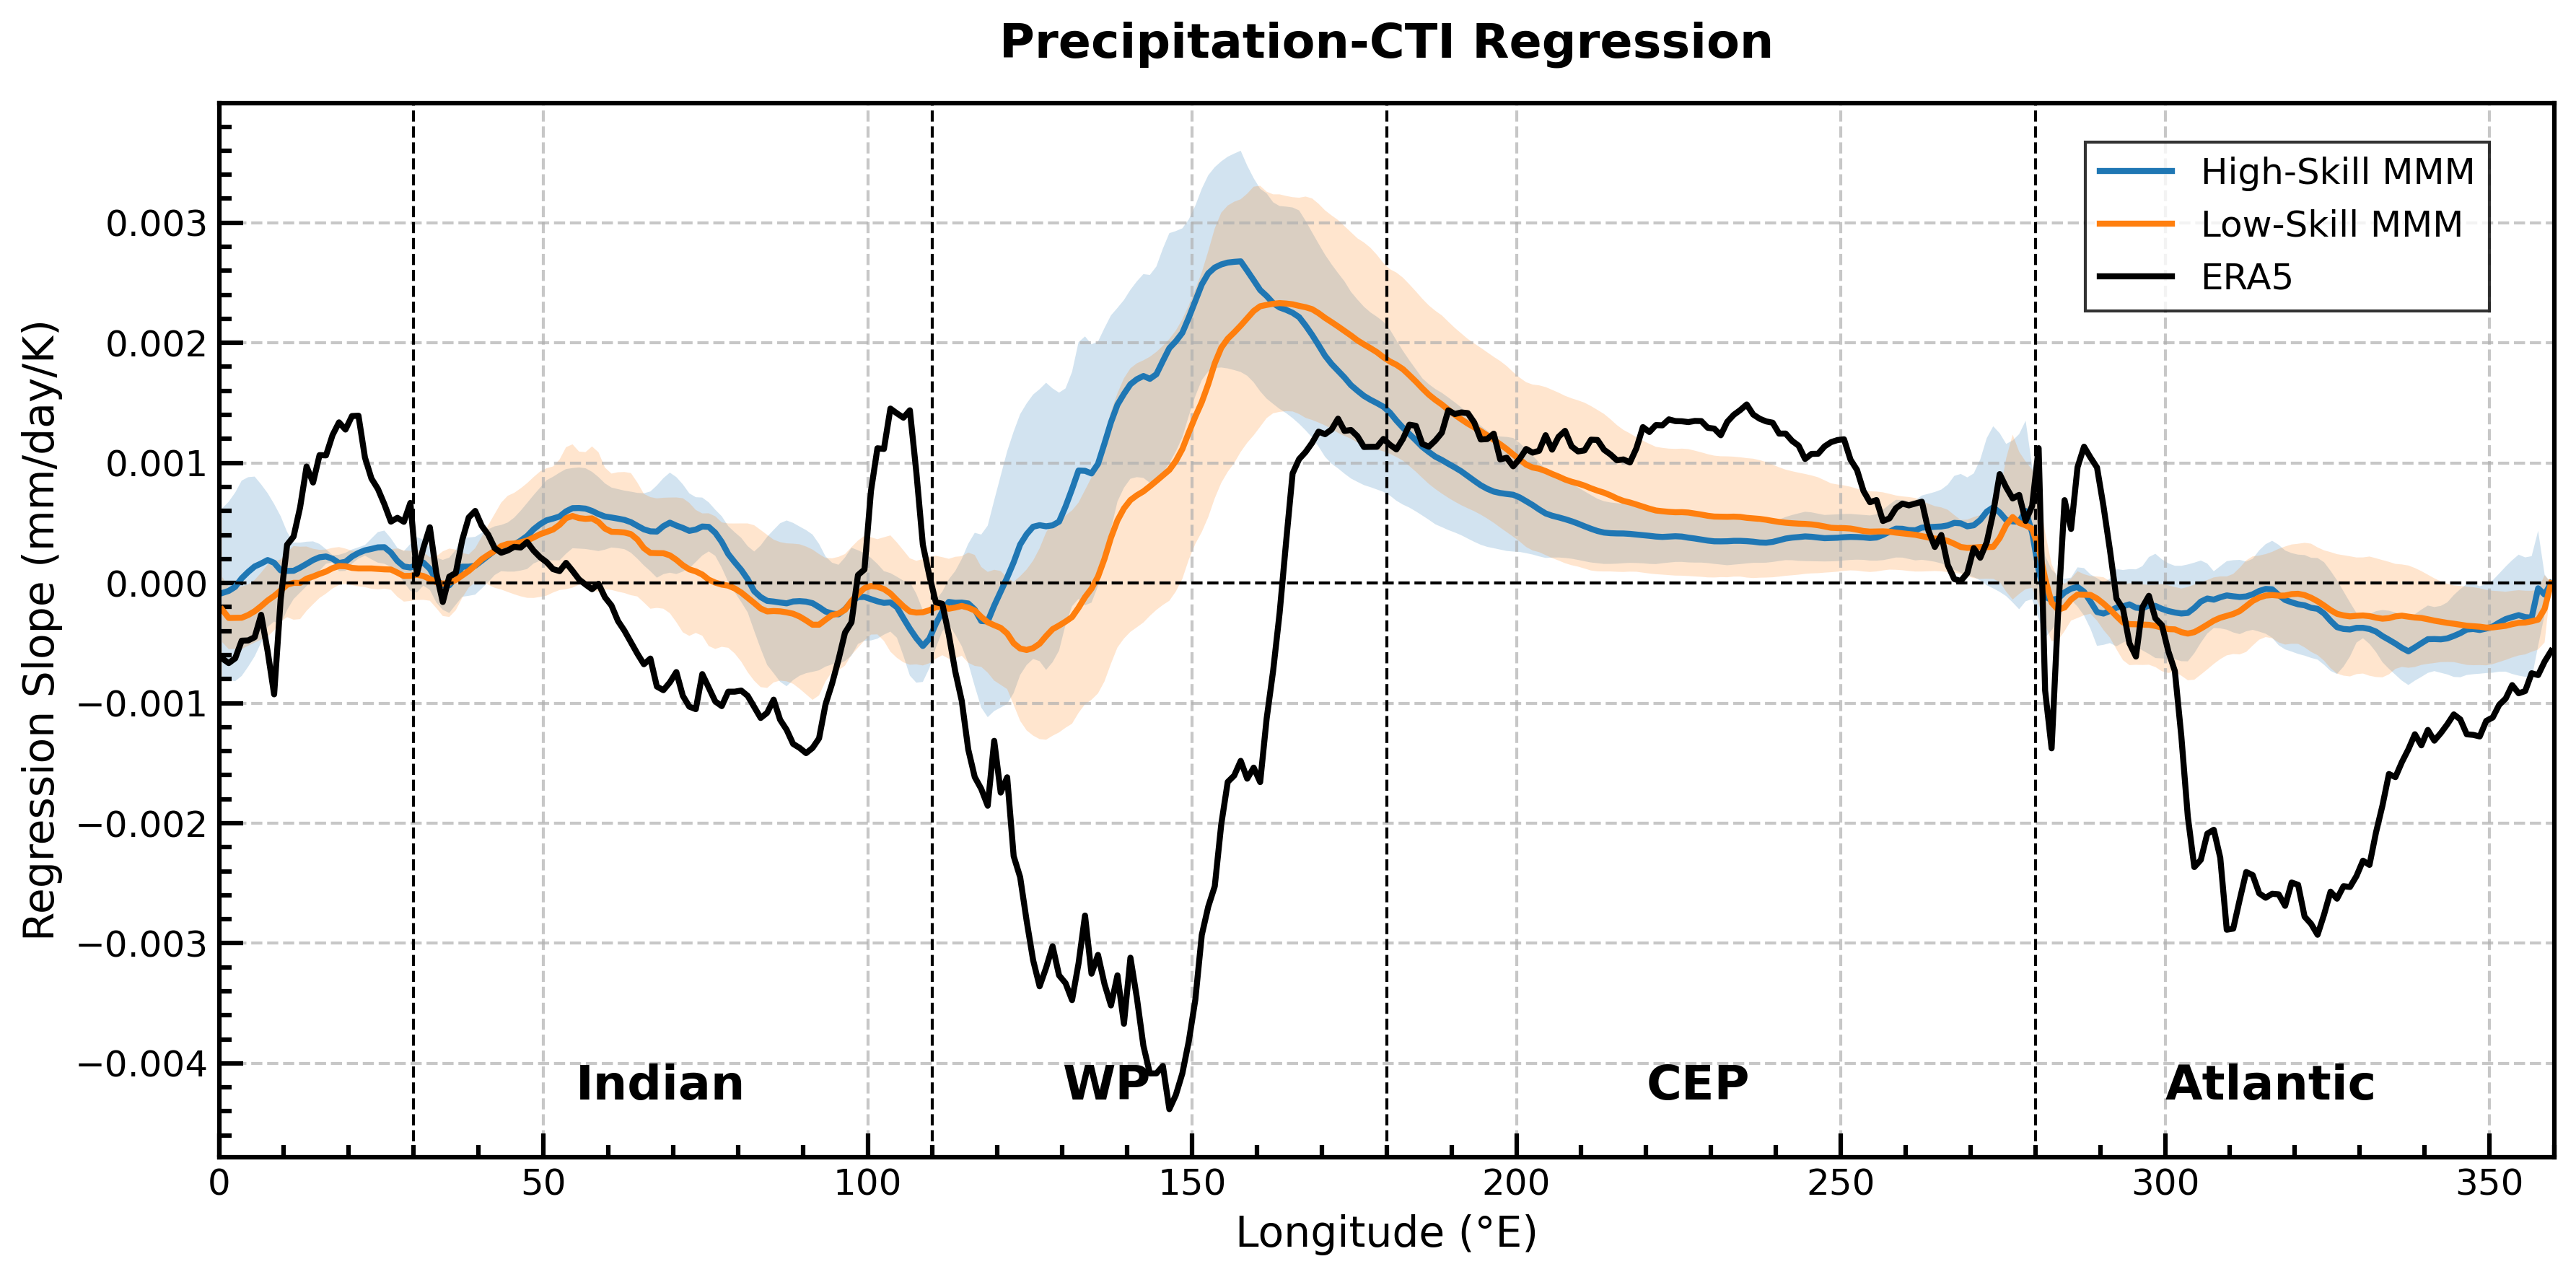

In [15]:
# First plot: NTA regression
plt.figure(figsize=(12, 6), dpi=300)

# Plot high skill MMM with shading
plt.plot(high_skill_mmm.lon, high_skill_mmm, label='High-Skill MMM', linewidth=2)
plt.fill_between(high_skill_mmm.lon, 
                 high_skill_mmm - high_skill_std,
                 high_skill_mmm + high_skill_std,
                 alpha=0.2)

# Plot low skill MMM with shading 
plt.plot(low_skill_mmm.lon, low_skill_mmm, label='Low-Skill MMM', linewidth=2)
plt.fill_between(low_skill_mmm.lon,
                 low_skill_mmm - low_skill_std, 
                 low_skill_mmm + low_skill_std,
                 alpha=0.2)

plt.plot(regression_prcp_ano_cti['ERA5'].lon, regression_prcp_ano_cti['ERA5'].slope, 
         label='ERA5', color='black', linewidth=2)

# Modify border style to make it bolder
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Add vertical lines
plt.axvline(30, color='k', linestyle='--', linewidth=1.0)
plt.axvline(110, color='k', linestyle='--', linewidth=1.0)
plt.axvline(180, color='k', linestyle='--', linewidth=1.0)
plt.axvline(280, color='k', linestyle='--', linewidth=1.0)

# Add horizontal line at y=0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1.0)

# Add region labels
y_position = plt.ylim()[0] * 0.9
plt.text(55, y_position, 'Indian', fontsize=16, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=16, fontweight='bold') 
plt.text(220, y_position, 'CEP', fontsize=16, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=16, fontweight='bold')

# Scientific style formatting
plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.0)
plt.legend(frameon=True, loc='upper right', fontsize=12, 
          bbox_to_anchor=(0.98, 0.98), 
          edgecolor='black', 
          fancybox=False)

plt.xlabel('Longitude (°E)', fontsize=14,)
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14, )
plt.title('Precipitation-CTI Regression', fontsize=16, fontweight='bold', pad=15)

# Set tick parameters
plt.tick_params(direction='in', length=8, width=1.5, which='major', labelsize=12)
plt.tick_params(direction='in', length=4, width=1.5, which='minor', labelsize=12)

# Add minor ticks
plt.minorticks_on()

# Set x-axis limits from 0 to 360
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()


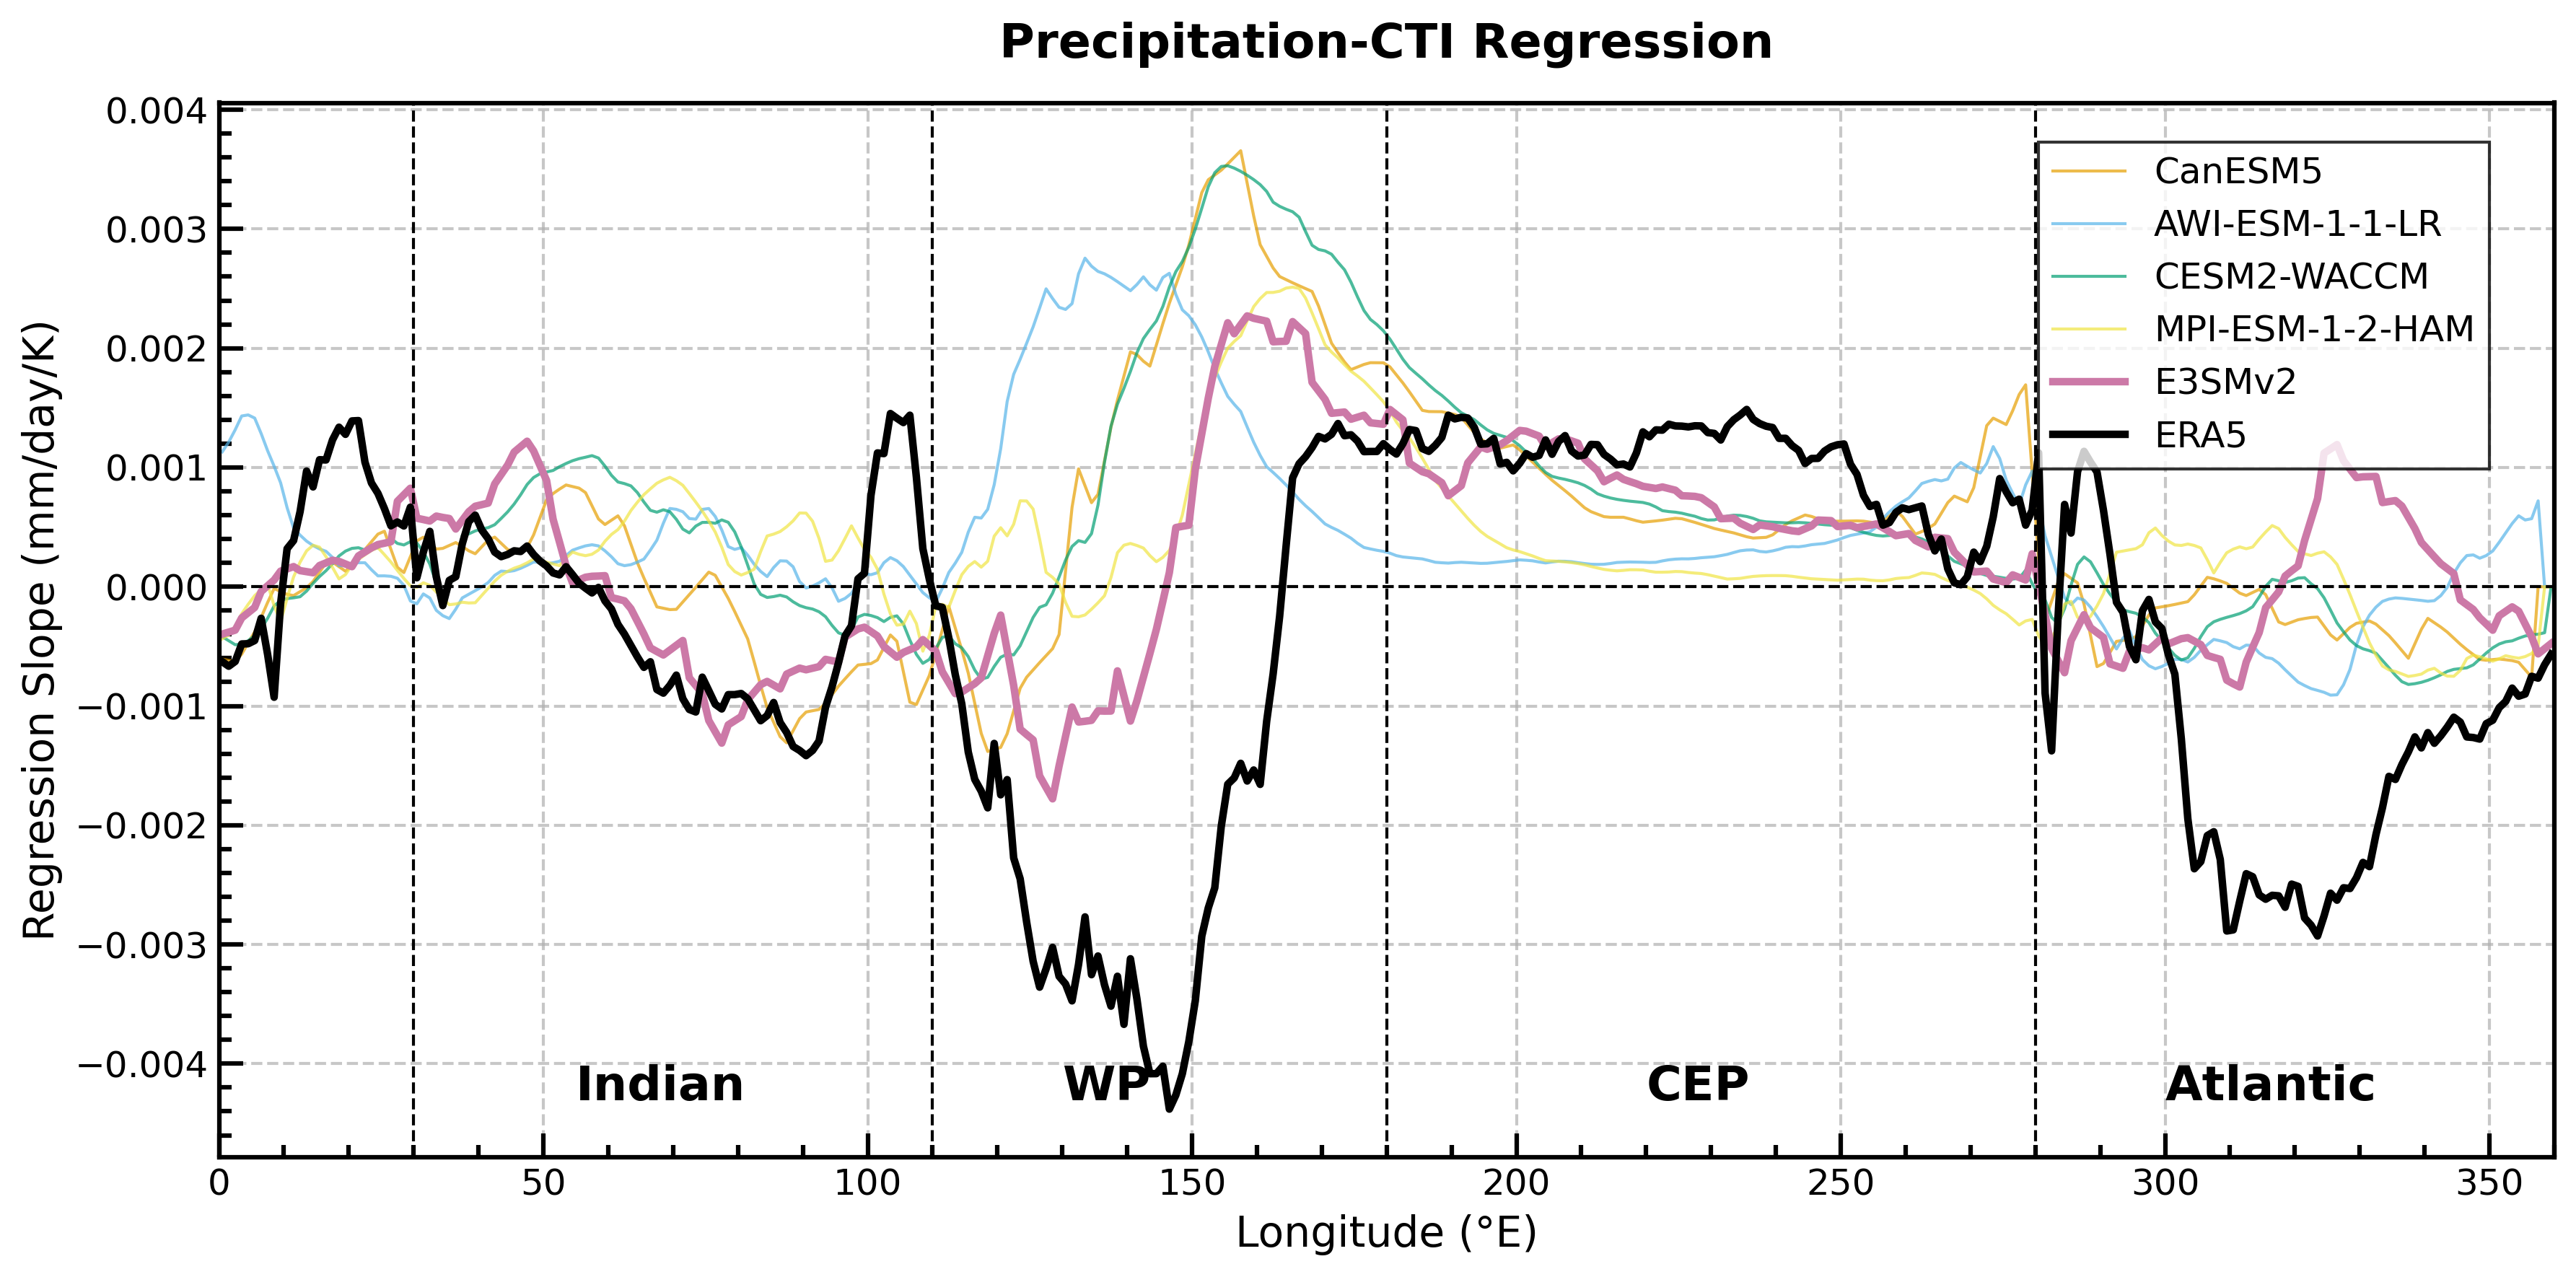

In [16]:
plt.figure(figsize=(12, 6), dpi=300)

colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']

high_skill_models = model_ranking[model_ranking['Distance'] < 1].index.tolist()
high_skill_models = [model for model in high_skill_models if model != 'E3SMv2']

# Plot individual models
for i, model in enumerate(high_skill_models):
    plt.plot(regression_prcp_ano_cti[model].lon, 
             regression_prcp_ano_cti[model].slope,
             label=model, linewidth=1, alpha=0.7,
             color=colors[i % len(colors)])

# Plot E3SMv2 and ERA5 with thicker lines
plt.plot(regression_prcp_ano_cti['E3SMv2'].lon, regression_prcp_ano_cti['E3SMv2'].slope,
         label='E3SMv2', linewidth=2.5, linestyle='-', color=colors[-2])

plt.plot(regression_prcp_ano_cti['ERA5'].lon, regression_prcp_ano_cti['ERA5'].slope, 
         label='ERA5', color='black', linewidth=2.5)

# Modify border style to make it bolder
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Add vertical lines
plt.axvline(30, color='k', linestyle='--', linewidth=1.0)
plt.axvline(110, color='k', linestyle='--', linewidth=1.0)
plt.axvline(180, color='k', linestyle='--', linewidth=1.0)
plt.axvline(280, color='k', linestyle='--', linewidth=1.0)

# Add horizontal line at y=0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1.0)

# Add region labels
y_position = plt.ylim()[0] * 0.9
plt.text(55, y_position, 'Indian', fontsize=16, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=16, fontweight='bold') 
plt.text(220, y_position, 'CEP', fontsize=16, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=16, fontweight='bold')

# Scientific style formatting
plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.0)
plt.legend(frameon=True, 
          loc='upper right', 
          fontsize=12,
          bbox_to_anchor=(0.98, 0.98),
          edgecolor='black',
          fancybox=False,
          ncol=1)

plt.xlabel('Longitude (°E)', fontsize=14)
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14)
plt.title('Precipitation-CTI Regression', 
         fontsize=16, fontweight='bold', pad=15)

# Set tick parameters
plt.tick_params(direction='in', length=8, width=1.5, which='major', labelsize=12)
plt.tick_params(direction='in', length=4, width=1.5, which='minor', labelsize=12)

# Add minor ticks
plt.minorticks_on()

# Set x-axis limits from 0 to 360
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()